In [31]:
%load_ext autoreload
%autoreload 2
%load_ext jupyternotify
import numpy as np 
import pickle
from sets import Set
from conf_ope_rl import * 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


# Generate gridworld

In [2]:

#'up':2, 'down':3, 'left':0, 'right':1
# indexing is j,i; j increasing goes downwards 
# (0,0), (0,1), (0,2)
# (1,0), (1,1), (1,2)... 
# (2,0), (2,1), (2,2) 

# The bad states are
# (0,0), (0,1) X, (0,2) X
# (1,0), (1,1),  (1,2) X... 
# (2,0) X, (2,1), (2,2) 



P_u0, R_u0 = grid_world_example()
[nA, nS,nS] = P_u0.shape
nU = 2
# make reward array
bad_Rwd = -0.3
living_Rwd = -0.1
R_u0_vec = np.asarray([living_Rwd, bad_Rwd, bad_Rwd, 
      living_Rwd  , living_Rwd, bad_Rwd, 
       bad_Rwd, bad_Rwd, 1])
R_u0 = np.zeros([nS,nA]); 
for a in range(nA): 
    R_u0[:,a] = R_u0_vec

# repeat for all actions

P_u1, R_u1 = westward_wind_grid_world_example()

P_u1
print R_u1.shape

(2, 2)
(2, 2)
(9, 4)


In [3]:
# build S,U transition matrix 
nU = 2
nS = 3*3
P_su = np.zeros([nS*nU, nA ,nS*nU])
P_su_mdptoolbox = np.zeros([nA , nS*nU, nS*nU])
Ps = [P_u0, P_u1]
for a_ind in range(nA): 
    for i_s in range(nS): 
        for i_sprime in range(nS): 
            for i_u in range(nU): 
                P_su[ i_s*nU + i_u,a_ind, i_sprime*nU:(i_sprime*nU+nU)] = Ps[i_u][a_ind, i_s, i_sprime]/nU
                P_su_mdptoolbox[ a_ind, i_s*nU + i_u, i_sprime*nU:(i_sprime*nU+nU)] = Ps[i_u][a_ind, i_s, i_sprime]/nU

# print [(P_su[:,a,:].sum(axis=1)) for a in range(nA)]
# print [(P_su_mdptoolbox[a,:,:].sum(axis=1)) for a in range(nA)]

In [4]:

import mdptoolbox.example
# P, R = mdptoolbox.example.forest()
vi = mdptoolbox.mdp.ValueIteration(P_u0, R_u0, 0.99)
vi.run()
pi_opt_s = vi.policy # result is (0, 0, 0)
pi_opt_s
pi_opt_s_ = np.zeros([nA, nS*nU])
for s in range(nS): 
    pi_opt_s_[pi_opt_s[s],s*nU] = 1
    pi_opt_s_[pi_opt_s[s],s*nU+1 ] = 1
# print pi_opt_s
uniform_pi = np.ones([nA, nS*nU])*1.0 / (nA)
# print uniform_pi
# print pi_opt_s_

# print np.round(pi_opt_s_,2)

In [5]:
# Reward matrix
R_u0

array([[-0.1, -0.1, -0.1, -0.1],
       [-0.3, -0.3, -0.3, -0.3],
       [-0.3, -0.3, -0.3, -0.3],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.3, -0.3, -0.3, -0.3],
       [-0.3, -0.3, -0.3, -0.3],
       [-0.3, -0.3, -0.3, -0.3],
       [ 1. ,  1. ,  1. ,  1. ]])

## Compute optimal full-information policy

In [6]:
vi = mdptoolbox.mdp.ValueIteration(P_u0*0.5+0.5*P_u1, R_u0, 0.99)
vi.run()
pi_opt_smarg = vi.policy # result is (0, 0, 0)
pi_opt_smarg_ = np.zeros([nA, nS*nU])
for s in range(nS): 
    pi_opt_smarg_[pi_opt_smarg[s],s*nU] = 1
    pi_opt_smarg_[pi_opt_smarg[s],s*nU+1 ] = 1


In [7]:
R_su = np.repeat(R_u0, 2 ).reshape([nS*nU, nA])
vi = mdptoolbox.mdp.ValueIteration(P_su_mdptoolbox, R_su, 0.99)
vi.run()
pi_opt_su = vi.policy # result is (0, 0, 0)
pi_opt_su
pi_opt_su_ = np.zeros([nA, nS*nU])
for su in range(nS*nU): 
    pi_opt_su_[pi_opt_su[su],su] = 1


#### Rename some quantities

In [8]:
# pi_opt_s_ optimal on state space s 
# pi_opt_su optimal on state space, unobserved state space U 

# Assume Suboptimal behavior policy 
mu_mix_behavior = 0.15
Pi = mu_mix_behavior*pi_opt_su_ + (1-mu_mix_behavior)*uniform_pi
nS = pi_opt_su_.shape[1] 
P = np.zeros([nS, nA, nS ])
# print p_e_su
P = P_su
state_dist = np.ones(nS)/nS
n = 40000
# get evaluation policy 

# Generate data

In [9]:
tight = False
nSmarg = nS / nU
[ stateChangeHist, stateHist, a_s, s_a_sprime, p_infty_b_su, distr_hist ] =  simulate_rollouts( 
    nS, nA, P, Pi, state_dist, n )
p_infty_b_s = (reshape_byxrow(p_infty_b_su.T, nU).T).flatten()
p_infty_b_su = p_infty_b_su.flatten()


[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]


In [10]:
print 'stationary state occupancy s',  p_infty_b_s
print('stationary distn on s,u: ', p_infty_b_su)

print sum(p_infty_b_su)

stationary state occupancy s [0.11562211 0.13694658 0.30951726 0.03804905 0.08649784 0.22569436
 0.01269968 0.02594935 0.04902377]
('stationary distn on s,u: ', array([0.05784855, 0.05777356, 0.06862328, 0.06832329, 0.15497113,
       0.15454614, 0.01909952, 0.01894953, 0.04297393, 0.04352391,
       0.11347216, 0.11222219, 0.00637484, 0.00632484, 0.01284968,
       0.01309967, 0.02494938, 0.0240744 ]))
1.0


## Change evaluation policy 

In [11]:
# Closer to optimal evaluation policy
mumix = 0 # mixing coef for policies
p_e_su = pi_opt_su_*mumix + uniform_pi*(1-mumix)
p_e_s = reshape_byxrow(p_e_su.T,nU).T / nU 
print p_e_su


[[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25 0.25 0.25]]


In [12]:
# process history 
print np.isclose(sum(p_infty_b_s),1)
[ p_a1_su, joint_s_a_sprime, s_a_giv_sprime ] = get_auxiliary_info_from_traj(stateChangeHist, 
                                        stateHist, a_s, s_a_sprime, p_infty_b_su, distr_hist, nA,nS)
# agg history and process
[aggStateHist, p_a1_s, p_e_s, agg_s_a_sprime, joint_s_a_sprime_agg, s_a_giv_sprime_agg] = agg_history(
            stateHist, s_a_sprime, p_infty_b_s, a_s, p_e_su, nA, nS, nSmarg, nU)
# # Simulate from evaluation policy: 
# [ stateChangeHist_e, stateHist_e, a_s_e, s_a_sprime_e, p_infty_e, distr_hist_e ] =  simulate_rollouts( 
#     nS, nA, P, p_e_su, state_dist, n )

print 'pi_e_s', p_e_s

True
pi_e_s [[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]]


In [13]:
# intermediate data save
# 
# data = {'p_a1_su': p_a1_su, 'joint_s_a_sprime': joint_s_a_sprime, 's_a_giv_sprime':s_a_giv_sprime,'aggStateHist':aggStateHist,'p_a1_s':p_a1_s,'p_e_s':p_e_s,'agg_s_a_sprime':agg_s_a_sprime,'joint_s_a_sprime_agg':joint_s_a_sprime_agg,'s_a_giv_sprime_agg':s_a_giv_sprime_agg   } 
# pickle.dump(data, open('data-0.15behaviormixture.p','wb'))

## Simulate to get real policy evaluation value

In [14]:
# [ stateChangeHist, stateHist, a_s, s_a_sprime, p_infty_b_su_long, distr_hist ] =  simulate_rollouts( 
#     nS, nA, P, Pi, state_dist, 10000 )
# [ stateChangeHist_e, stateHist_e, a_s, s_a_sprime_e, p_infty_e_long, distr_hist_e ] =  simulate_rollouts( 
#     nS, nA, P, p_e_su, state_dist, 10000 )

# print p_infty_b_su_long
# print p_infty_e_long
# w_su_oracle_norm = p_infty_b_su_long/p_infty_e_long
# w_s_oracle_norm = reshape_byxrow(w_su_oracle_norm.T,nU).T.flatten()
# w_s_oracle_normalized = w_s_oracle_norm / np.dot(w_s_oracle_norm, p_infty_b_s)



In [32]:
# pickle.dump({'min_bnds':min_bnds, 'max_bnds':max_bnds}, open('bnds-pi-smarg.p','w'))

# Generate figure

In [20]:
%%notify
tight = True; quiet = True; sense_min = False
# fix parameters
ngams = 25
logGams_full = np.linspace(0.1, 1.7, ngams)
phi = R_u0_vec
nmus = 5
# set evaluation policy
PI_E = pi_opt_s_



min_bnds = [[None] * ngams for m_ in range(nmus)];
max_bnds = [[None] * ngams for m_ in range(nmus)];
gamma = 1
mus = np.linspace(0.3,0.95,nmus)

print nA, nS
for m_ in range(nmus): 
    p_e_su = PI_E*mus[m_] + uniform_pi*(1-mus[m_])
    p_e_s = reshape_byxrow(p_e_su.T,nU).T / nU 
    for ind,logGam in enumerate(logGams_full): 
        sense_min = False
        [a_bnd, b_bnd] = get_bnds_as( p_a1_s, logGam )
        [objVal, w_, m] = primal_opt_outer_L1_test_function_joint_distn(gamma, phi, a_bnd,b_bnd, joint_s_a_sprime_agg, p_infty_b_s, p_e_s, nSmarg, nA, tight, sense_min, quiet)
        print objVal
        print w_
        min_bnds[m_][ind] = objVal#; w_min_bnds[ind] = w_; 
        sense_min = True
        [objVal, w_, m] = primal_opt_outer_L1_test_function_joint_distn(gamma, phi, a_bnd,b_bnd, joint_s_a_sprime_agg, p_infty_b_s, p_e_s, nSmarg, nA, tight, sense_min, quiet)
        print objVal
        max_bnds[m_][ind] = objVal#; w_max_bnds[ind] = w_; 
        print w_  



4 18
9

--------------------------------------------
--------------------------------------------

Using license file /Users/az/gurobi.lic
Academic license - for non-commercial use only
None
None
9
None
None
9
None
None
9
None
None
9
None
None
9
None
None
9
-0.135954722347
[1.1692936507725635, 0.8561677924782077, 0.6643508585563435, 1.42313840472535, 1.2779154352913062, 1.0664690842298805, 1.0937338592803545, 1.6417145727643752, 1.6329414791555739]
9
-0.153751415515
[1.1718596314836431, 0.9438790284223699, 0.7817810521688991, 1.3357139765683226, 1.1556039945840433, 1.0134705324743238, 0.9198488554799368, 1.295530554635972, 1.396403000874729]
9
-0.132715347486
[1.170178051594183, 0.8385836828406907, 0.6474374386585104, 1.4348191173570446, 1.2927101803581018, 1.0751145168678518, 1.1192523666747958, 1.6929885433742713, 1.6780387962834606]
9
-0.156692112939
[1.175095737831451, 0.9542315392814088, 0.7955488245528787, 1.3267687966724218, 1.142021667383416, 1.0096716197437563, 0.8956206629709

-0.0607977390574
[1.7896745660080955, 0.6757600197661446, 0.3823552523389503, 2.252440169053601, 1.707154967029841, 0.5776979724373357, 2.0063094670998805, 2.955382182009981, 2.371586961817879]
9
-0.19930096438
[0.6089576615012506, 0.8484992774150792, 1.0241992906252757, 0.6360406963409754, 0.8819892857932412, 1.4452683588699549, 0.31081674514087415, 0.5622103717284667, 1.0437488381979236]
9
-0.0553956232835
[1.795307893101006, 0.6560734482048436, 0.36746093459950996, 2.2757954756908534, 1.7423370318391336, 0.5606072891777129, 2.0599575235621024, 3.0497384913746557, 2.4419685808197165]
9
-0.202484321565
[0.5922546717597423, 0.8599327795239111, 1.0473161047283663, 0.6054967084370696, 0.8265790114532414, 1.452925107067462, 0.2904096287035183, 0.5210526571496018, 1.0185475258848276]
9
None
None
9
None
None
9
None
None
9
None
None
9
None
None
9
None
None
9
-0.107287093202
[1.2427349379145776, 0.7876067219854749, 0.5240830830525822, 1.6532040116866318, 1.4074802217669489, 1.0537561905039918

-0.191700999349
[1.2966062876070117, 1.0330009142005026, 0.8929021671956, 1.0057003994144529, 0.7549254606641439, 1.1814442633893327, 0.33962443816936944, 0.5169896849761489, 0.9038417952562875]
9
0.00476367669929
[1.0940614746862005, 0.39333308039197157, 0.21144181661682648, 2.375244474447777, 2.001410431711335, 0.8047207933419674, 2.099571229132448, 4.161126712077814, 3.558170686383519]
9
-0.193050406907
[1.2966488581586015, 1.0351068706827335, 0.8992603618336898, 0.9793616765501174, 0.738669458740289, 1.1882093508531837, 0.3248615037922213, 0.4967917954627566, 0.8902104576662566]
9
0.0137365314951
[1.0879067916594345, 0.377963399055164, 0.19928875258378909, 2.4349118645915064, 2.0423221881583475, 0.7552619847821851, 2.1890399074657543, 4.34137541624878, 3.6829667313628103]
9
-0.195074058187
[0.5256514628030868, 0.737014999583053, 0.9515004313256848, 0.5563920844164101, 0.7853250114880481, 1.6938299984502025, 0.19765378976236336, 0.47145879365207727, 1.1760500282139057]
9
None
None
9

-0.186679697808
[1.4213729811662748, 1.0548264125680014, 0.8332535332097915, 1.1120037678707246, 0.732203370091036, 1.1762925337352848, 0.2881086788384986, 0.4962529595449095, 0.9308346296553278]
9
0.0535749962798
[1.2200167981637469, 0.36099082897243057, 0.14668676686363466, 2.6227177244011677, 2.0649004582426485, 0.557556296027249, 1.926805441951907, 4.930526397055522, 4.231581804995253]
9
-0.188272201818
[1.4229370108406991, 1.0585396313114694, 0.8398253662707167, 1.0809876006599444, 0.714276900432882, 1.1834116504006942, 0.2741859615611953, 0.47351913980650917, 0.9138487739050885]
9
0.0656009016159
[1.2255051996473543, 0.34968946948373136, 0.13716199269280943, 2.7174113937620916, 2.1036973495508113, 0.47464716110189176, 2.02273320583329, 5.1738360780865635, 4.396450304677551]
9
-0.189796705834
[1.42468334767272, 1.062284597827722, 0.8463261236263282, 1.0503428453840649, 0.6970458966839835, 1.1898669828624344, 0.2608526289850849, 0.451824883543335, 0.8976306243601496]
9
0.0780303534

-0.184725850518
[1.5468520473042964, 1.0840191841093831, 0.7896103014023633, 1.161934528674337, 0.6755463276039188, 1.178952006628795, 0.22322512261254657, 0.4382316153176209, 0.9253803712494927]
9
0.108049463986
[1.3145265845343919, 0.3237608158557528, 0.10263100249741104, 2.5791231767852794, 2.086120619714646, 0.33740742309365834, 1.5583349467979695, 5.770665750179807, 5.05149215641038]
9
-0.186384440725
[1.5504119892169659, 1.0892238914449754, 0.7961950418588313, 1.1275067731654327, 0.657767105045874, 1.1846422273529347, 0.21170376788316675, 0.41697665161854447, 0.907000744547815]
9
0.116743332308
[1.3174362734160252, 0.31557212424431985, 0.09845696201501306, 2.4024473679835703, 2.0833135560384957, 0.3260005997317862, 1.525157088825749, 5.937548020688212, 5.2087096548659035]
9
-0.187948479803
[1.553920910163576, 1.094216339160804, 0.8025091448494812, 1.0936647808599258, 0.6409825010775257, 1.1898255470763308, 0.2016273009178212, 0.3976290483976708, 0.8897833002977842]
9
None
None
9


-0.18148823526
[1.6924473036207957, 1.1252140240923822, 0.7516190736774826, 2.0833559167782676, 0.7273340287719882, 0.9376143493627768, 0.7680398848601382, 0.5722048573714507, 0.7992729990716816]
9
0.151334505007
[1.3384021563876323, 0.2946654167606918, 0.07960855495658965, 2.2544312106290345, 2.0116060172991634, 0.300353687440377, 0.9394063322303611, 6.063878336540817, 5.7810102050117225]
9
-0.183413594643
[1.7065684019520835, 1.1376074869530577, 0.7621010074975992, 2.0844894950701756, 0.7110590873694905, 0.9236724327473852, 0.7700976500303707, 0.5503581768731123, 0.7682208991160812]
9
0.160590904328
[1.3473002652493018, 0.28975800110445243, 0.07703119735490278, 2.028799187100251, 1.9986458173476425, 0.2904566937851251, 0.8696900008612015, 6.249273365405441, 5.953483168134046]
9
-0.185253123867
[1.720514880516723, 1.1497205619962017, 0.7723595451139255, 2.058519392168279, 0.6930911210624323, 0.9151972582296519, 0.7620433133287728, 0.5265745351859892, 0.7422748083589723]


<IPython.core.display.Javascript object>

## Get true evaluation policy values (by simulation) 

In [28]:
w_s_normalized_ = [None]* nmus
vals = [None] * nmus

for m_ in range(nmus): 

    p_e_su = PI_E*mus[m_] + uniform_pi*(1-mus[m_])
    [ stateChangeHist_e, stateHist_e, a_s, s_a_sprime_e, p_infty_e_long, distr_hist_e ] =  simulate_rollouts( 
        nS, nA, P, p_e_su, state_dist, 20000 )

    w_su_oracle_norm = p_infty_b_su/p_infty_e_long

    w_s_oracle_norm = reshape_byxrow(w_su_oracle_norm.T,nU).T.flatten()
    w_s_oracle_normalized = w_s_oracle_norm / np.dot(w_s_oracle_norm, p_infty_b_s)
    w_s_normalized_[m_] = w_s_oracle_normalized
    # stationary evaluation occupancy
    vals[m_] = np.dot(np.ones(len(phi)), phi*reshape_byxrow(p_infty_e_long.T,nU).T.flatten())


print vals


[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.

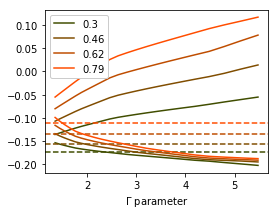

In [30]:
import pickle
plt.figure(figsize=(4.,3))
gams___ = np.exp(logGams_full)
scenario_title = 'mixture-pi-opt-s-ka-ctrl-var'
# load from output
# vals_ = pickle.load( open('policy_smarg_-vals.p', 'r') )
# vals = vals_['vals']

for m_ in range(nmus-1): 
    plt.plot(np.exp(logGams_full),min_bnds[m_],color=((m_+1)*1.0/(nmus-1), 0.3,0),label=np.round(mus[m_],2)) #if m_%2 ==0 else None ) 
    plt.plot(np.exp(logGams_full),max_bnds[m_],color=((m_+1)*1.0/(nmus-1), 0.3,0))

    plt.axhline(vals[m_], linestyle='--',color=((m_+1)*1.0/(nmus-1), 0.3,0 ))
plt.xlabel(r'$\Gamma$ parameter')
plt.legend(framealpha=1)
plt.savefig("3-3gridworld-"+scenario_title+".pdf",bbox_inches = 'tight')
# optional output storage 
# pickle.dump({'min_bnds':min_bnds, 'max_bnds':max_bnds}, open('bnds-'+scenario_title+'.p','w'))
# pickle.dump( {'pib':p_a1_su, 'pie-mix-comp':p_e_su}, open(scenario_title+'-params.p', 'w') )

Figure 6 is generated by changing PI_E to pi_opt_smarg_